# Create training masks

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time

import geopandas as gpd
import rasterio
from collections import Counter
import shapely.geometry
from descartes import PolygonPatch
import cv2
from geopandas.geoseries import *
import h5py # just a safety check so the checkpoint callback doesnt crash
from scipy.misc import imresize
from shapely.ops import unary_union

# %pylab inline
%matplotlib inline
plt.style.use('ggplot')
from matplotlib.collections import PatchCollection

In [2]:
# Recycle a couple of functions from previous notebooks...
def polycoords(poly):
    """Convert a polygon into the format expected by OpenCV
    """
    if poly.type in ['MultiPolygon', 'GeometryCollection']:
        return [np.array(p.exterior.coords) for p in poly if p.type == 'Polygon']
    elif poly.type == 'Polygon':
        return [np.array(poly.exterior.coords)]
    else:
        print('Encountered unrecognized geometry type {}. Ignoring.'.format(poly.type))
        return []

    
def make_mask(img_shape, poly):
    """Make a mask from a polygon"""
    poly_pts = polycoords(poly)
    polys = [x.astype(int) for x in poly_pts]
    # Create an empty mask and then fill in the polygons
    mask = np.zeros(img_shape[:2])
    cv2.fillPoly(mask, polys, 255)
    return mask.astype('uint8')


def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """Rescale the bands of a multichannel image for display"""
    img_scaled = np.zeros(img.shape, np.uint8)
    for i in range(img.shape[2]):
        band = img[:, :, i]
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        band = (band - lower) / (upper - lower) * 255
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
    return img_scaled


def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized


# Build a training set
def make_set(image_summary, vectors, training_set_size, validation_set_size, input_size, random=np.random):
    rows_to_use = random.choice(image_summary.index, training_set_size + validation_set_size, replace=False)
    
    train_rows_to_use = rows_to_use[:training_set_size]
    val_rows_to_use = rows_to_use[training_set_size:]
    
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    
    
    # make training set
    for i, row in image_summary.loc[train_rows_to_use].iterrows():
        with rasterio.open(row.image_name) as src:
            img = src.read().transpose([1,2,0])
#             img = resize(img, (input_size, input_size))
            # img = scale_bands(img, lower_pct = 5, upper_pct = 95)
            img_bounds = shapely.geometry.box(*src.bounds)
            img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
           
        masks = []
        for poly in vectors:
            # Get the intersection between the polygon and the image bounds
            mask_poly = poly.intersection(img_bounds)

            # Transform it into pixel coordinates
            mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

            # Convert the polygon into a mask
            mask = make_mask(img.shape[:2], mask_poly_pxcoords)
            mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))
            
            masks.append(mask[..., None])
        masks = np.concatenate(masks, axis=2)
        img = resize(img, (input_size, input_size))
        
        # Add each mask to a list
        X_train.append(img[None, ...]) # These need to be truncated for U-Net
        Y_train.append(masks[None, ...])
        
    # make validation set
    for i, row in image_summary.loc[val_rows_to_use].iterrows():
        with rasterio.open(row.image_name) as src:
            img = src.read().transpose([1,2,0])
#             img = resize(img, (input_size, input_size))
            # img = scale_bands(img, lower_pct = 5, upper_pct = 95)
            img_bounds = shapely.geometry.box(*src.bounds)
            img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])
           
        masks = []
        for poly in vectors:
            # Get the intersection between the polygon and the image bounds
            mask_poly = poly.intersection(img_bounds)

            # Transform it into pixel coordinates
            mask_poly_pxcoords = shapely.affinity.affine_transform(mask_poly, img_transform)

            # Convert the polygon into a mask
            mask = make_mask(img.shape[:2], mask_poly_pxcoords)
            mask = imresize(mask, (INPUT_SIZE, INPUT_SIZE))
            
            masks.append(mask[..., None])
        masks = np.concatenate(masks, axis=2)
        img = resize(img, (input_size, input_size))
        
        # Add each mask to a list
        X_val.append(img[None, ...]) # These need to be truncated for U-Net
        Y_val.append(masks[None, ...])

            
    # Concatenate the results
    X_train = np.concatenate(X_train, axis=0)
    Y_train = np.concatenate(Y_train, axis=0)
    X_val = np.concatenate(X_val, axis=0)
    Y_val = np.concatenate(Y_val, axis=0)
    
    # Normalize the values
    X_train = X_train.astype('float32')
    X_train = (X_train / X_train.max() - 0.5) * 2 # put X in range [-1, 1]
    Y_train = Y_train.astype('float32') / 255 # put Y in range [0, 1]
    X_val = X_val.astype('float32')
    X_val = (X_val / X_val.max() - 0.5) * 2 # put X in range [-1, 1]
    Y_val = Y_val.astype('float32') / 255 # put Y in range [0, 1]
    
    return X_train, Y_train, X_val, Y_val, train_rows_to_use, val_rows_to_use

### Load-in water shapefiles

In [3]:
# East China Sea/Shanghai coast shapefile
sea = gpd.read_file('../AOI_4_Shanghai_Train/geojson/shanghai_coastal_waters.geojson')
sea.head()

,FID,geometry
0,36119.0,"POLYGON ((120.9374 32.64601833723218, 120.9374..."


In [5]:
# Interior waterways shapefiles
water_files = ! ls ../AOI_4_Shanghai_Train/line_water_geojson_full/
print('There are {} waterway shapefiles'.format(len(water_files)))

There are 906 waterway shapefiles


In [15]:
# instantiate waterways geo-dataframe
waterways = gpd.read_file('../AOI_4_Shanghai_Train/line_water_geojson_full/{}'.format(water_files[1]))
waterways.head()

,geometry,polygon
0,"POLYGON ((121.6164838295455 31.29048203253802,...",1023_poly


In [16]:
# load-in rest of waterways shapefiles
for file in water_files[2:]:
    waterways = waterways.append(gpd.read_file('../AOI_4_Shanghai_Train/line_water_geojson_full/{}'.format(file)), ignore_index=True)

In [18]:
# clean up dataframe
waterways.drop(['4297_poly','id','polyon'], axis=1, inplace=True)

In [19]:
# view data frame
print(waterways.shape)
waterways.head()

(2276, 2)


,geometry,polygon
0,"POLYGON ((121.6164838295455 31.29048203253802,...",1023_poly
1,"POLYGON ((121.6177021766529 31.29088771311653,...",1024_poly
2,"POLYGON ((121.6166574440083 31.32598408698347,...",1043_ply
3,"POLYGON ((121.6164929671488 31.32669740020661,...",1044_poly
4,"POLYGON ((121.6182504328513 31.34088664772728,...",1052_poly


In [20]:
# load-in summary data of satellite images
image_summary = gpd.read_file('../AOI_4_Shanghai_Train/vectors/image_summary.geojson')

In [25]:
part1 = sea.unary_union
part2 = unary_union([x.buffer(0) for x in waterways.geometry])
all_water = part1.union(part2)

images_containing_water = image_summary[image_summary.intersects(all_water)]
images_containing_water.head()

,geometry,image_name
0,"POLYGON ((121.6077192 31.3417809, 121.6077192 ...",../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-Pan...
1,"POLYGON ((121.7375892 31.2452559001, 121.73758...",../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-Pan...
3,"POLYGON ((121.6357992 31.3084359001, 121.63579...",../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-Pan...
5,"POLYGON ((121.6270242 31.3681059, 121.6270242 ...",../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-Pan...
12,"POLYGON ((121.6252692 31.4119809, 121.6252692 ...",../AOI_4_Shanghai_Train/MUL-PanSharpen/MUL-Pan...


In [26]:
images_containing_water.shape

(1938, 2)

### Inspect data

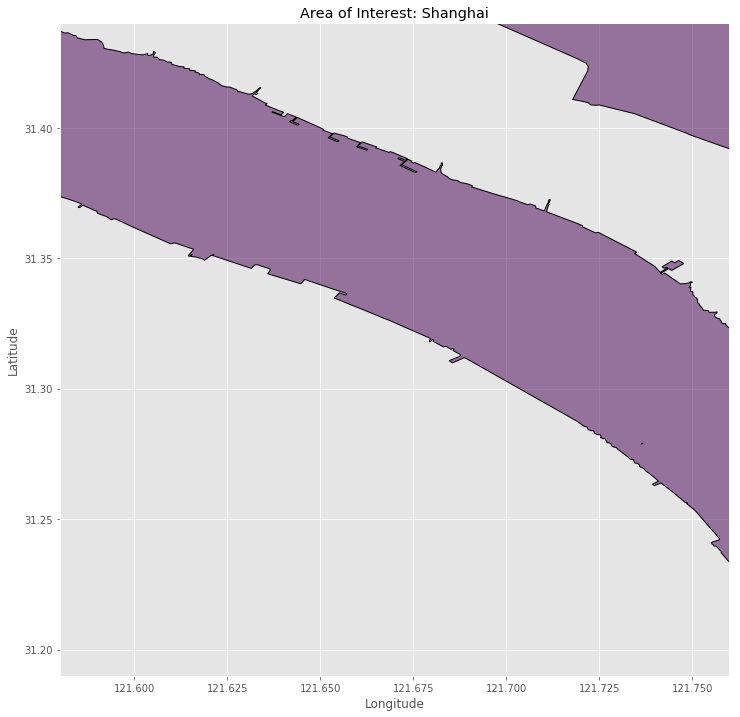

In [22]:
# plot sea/coastal shapefile
fig, ax = plt.subplots(figsize=(12,12))
sea.plot(ax=ax)
ax.set(title='Area of Interest: Shanghai',
       xlabel='Longitude',
       ylabel='Latitude',
       xlim=(121.580,121.760),
       ylim=(31.190,31.440));

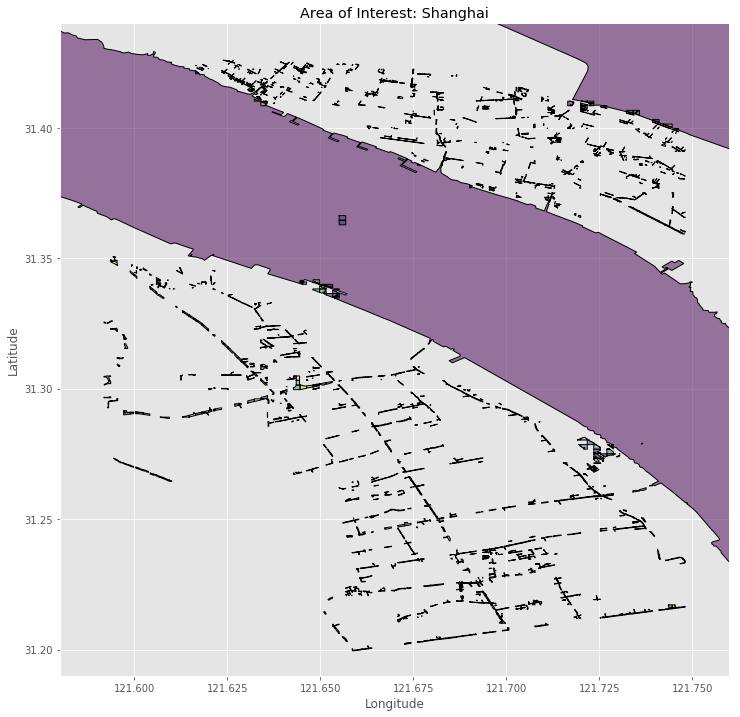

In [23]:
# add-in interior waterways
fig, ax = plt.subplots(figsize=(12,12))
sea.plot(ax=ax)
waterways.plot(ax=ax)
ax.set(title='Area of Interest: Shanghai',
       xlabel='Longitude',
       ylabel='Latitude',
       xlim=(121.580,121.760),
       ylim=(31.190,31.440));

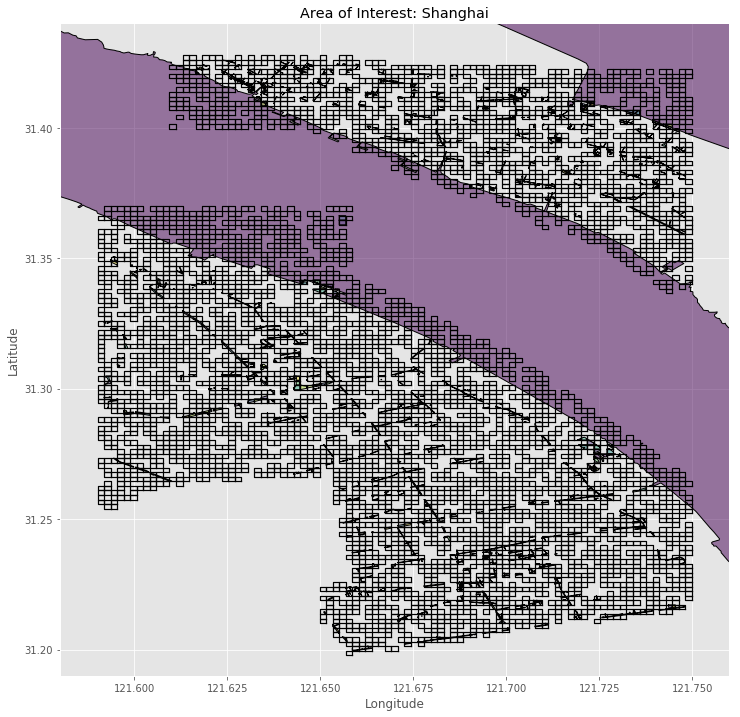

In [24]:
# add-in image summary
fig, ax = plt.subplots(figsize=(12,12))
sea.plot(ax=ax)
waterways.plot(ax=ax)
image_summary.plot(color='w', alpha=0.1, linewidth=1.2, ax=ax)
ax.set(title='Area of Interest: Shanghai',
       xlabel='Longitude',
       ylabel='Latitude',
       xlim=(121.580,121.760),
       ylim=(31.190,31.440));

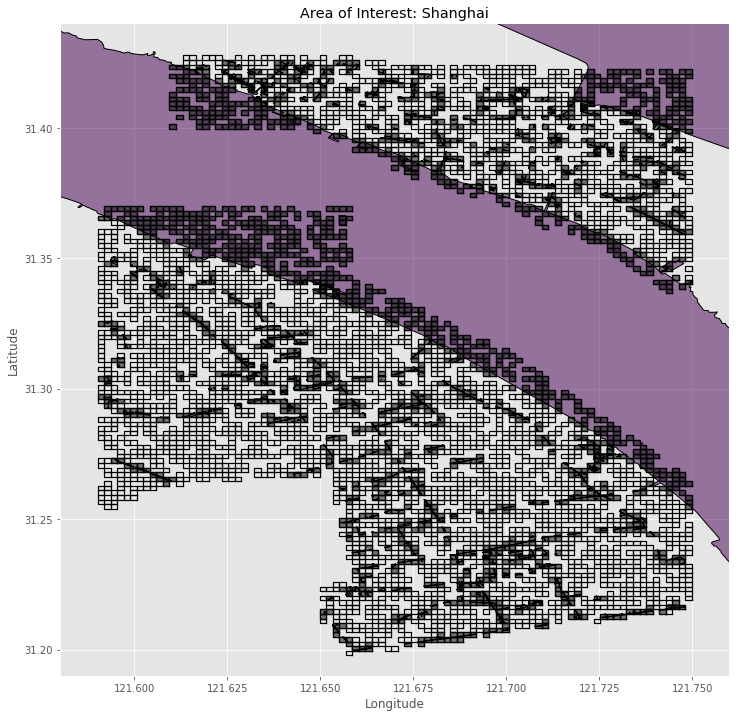

In [29]:
# highlight images containing water
fig, ax = plt.subplots(figsize=(12,12))
sea.plot(ax=ax)
waterways.plot(ax=ax)
image_summary.plot(color='w', alpha=0.1, linewidth=1.2, ax=ax)
images_containing_water.plot(color='k', alpha=0.5, linewidth=1.2, ax=ax)
ax.set(title='Area of Interest: Shanghai',
       xlabel='Longitude',
       ylabel='Latitude',
       xlim=(121.580,121.760),
       ylim=(31.190,31.440));

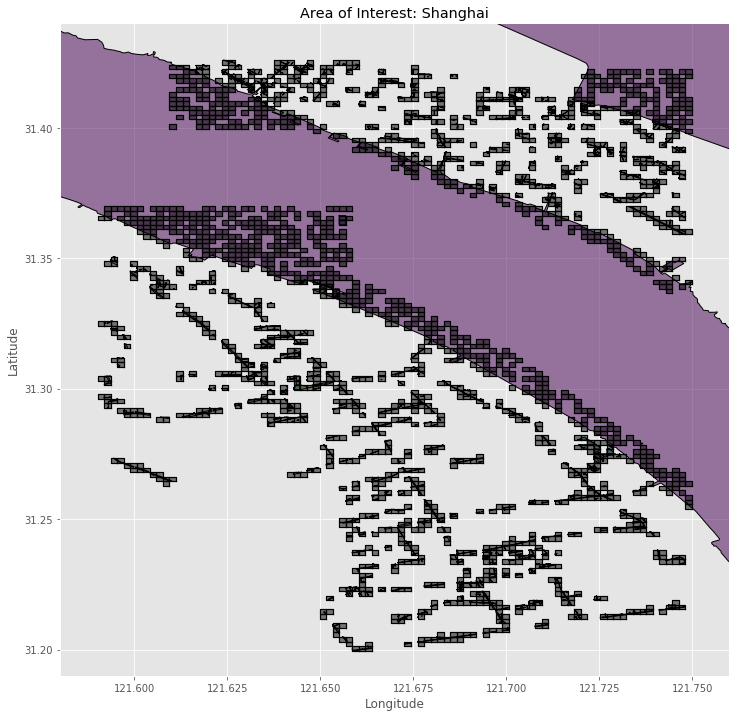

In [46]:
# isolate images containing water
fig, ax = plt.subplots(figsize=(12,12))
sea.plot(ax=ax)
waterways.plot(ax=ax)
images_containing_water.plot(color='k', alpha=0.5, linewidth=1.2, ax=ax)

ax.set(title='Area of Interest: Shanghai',
       xlabel='Longitude',
       ylabel='Latitude',
       xlim=(121.580,121.760),
       ylim=(31.190,31.440));

### Walk through training mask example

In [34]:
file_name = images_containing_water.image_name.values[2]

with rasterio.open(file_name) as src:
        img = scale_bands(src.read([5, 3, 2]).transpose([1,2,0]))
        img_bounds = shapely.geometry.box(*src.bounds)
        img_transform = list(np.array(~src.affine)[[0, 1, 3, 4, 2, 5]])

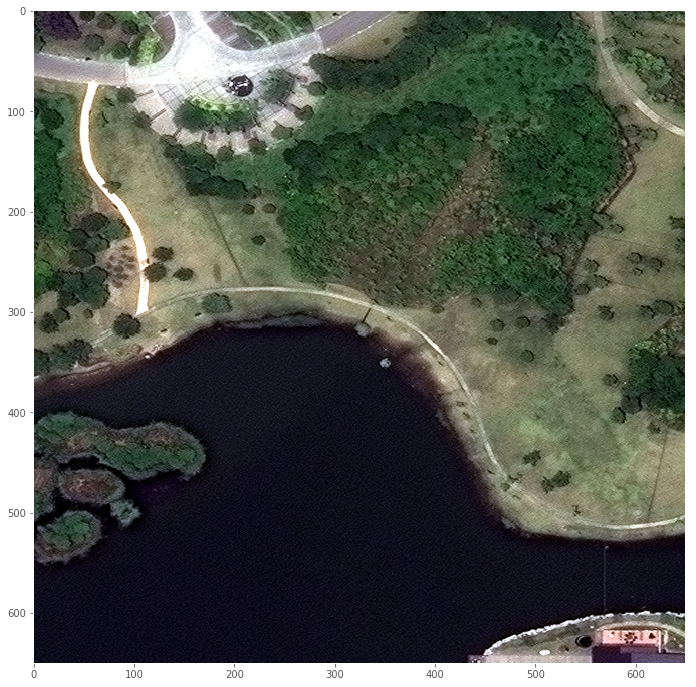

In [47]:
# plot example image
fig, ax = plt.subplots(figsize=(12,12))

ax.imshow(scale_bands(img));
ax.grid();

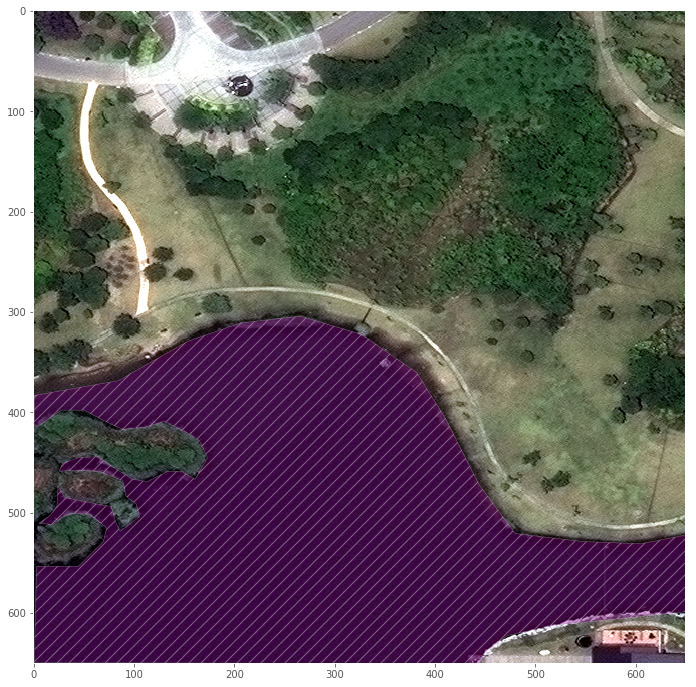

In [48]:
# Get the intersection between the forest and the image bounds
image_water_area = all_water.intersection(img_bounds)

# Transform it into pixel coordinates
image_water_area_pxcoords = shapely.affinity.affine_transform(image_water_area, img_transform)


# plot mask overlay for image
fig, ax = plt.subplots(figsize=(12,12))

ax.imshow(scale_bands(img));
ax.add_patch(PolygonPatch(image_water_area_pxcoords, fc='purple', alpha=0.4, hatch='//'));
ax.grid();

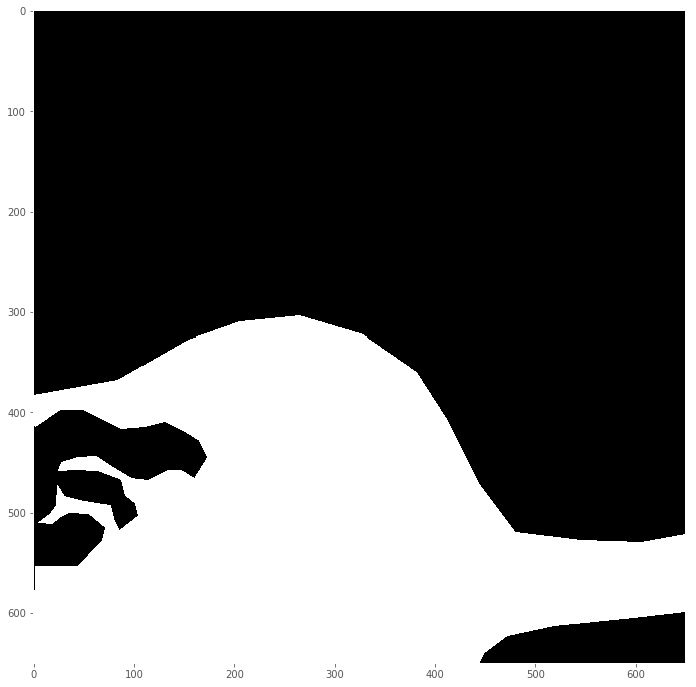

In [49]:
# plot training mask
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(make_mask(img.shape, 
                     shapely.affinity.affine_transform(all_water.intersection(img_bounds), 
                                                       img_transform)), 
           cmap=plt.cm.gray, 
           vmin=0, vmax=255);
ax.grid();

### Create training/validation sets

In [50]:
vectors = [all_water]

In [51]:
INPUT_SIZE = 240
random = np.random.RandomState(2) 
X_train, Y_train, X_val, Y_val, train_rows, val_rows = make_set(image_summary, 
                                                                vectors, 
                                                                4000, 
                                                                500, 
                                                                INPUT_SIZE, 
                                                                random)

In [52]:
# verify shape of sets
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(4000, 240, 240, 8)
(4000, 240, 240, 1)
(500, 240, 240, 8)
(500, 240, 240, 1)


### Pickle training/validation sets

In [53]:
# set, random state, size, mark
pickle.dump(X_train, open('../pickle_jar/X_train_r2_4000_V.p','wb'),protocol=4)
pickle.dump(Y_train, open('../pickle_jar/Y_train_r2_4000_V.p','wb'),protocol=4)
pickle.dump(X_val, open('../pickle_jar/X_val_r2_500_III.p','wb'),protocol=4)
pickle.dump(Y_val, open('../pickle_jar/Y_val_r2_500_III.p','wb'),protocol=4)

### Verify training masks

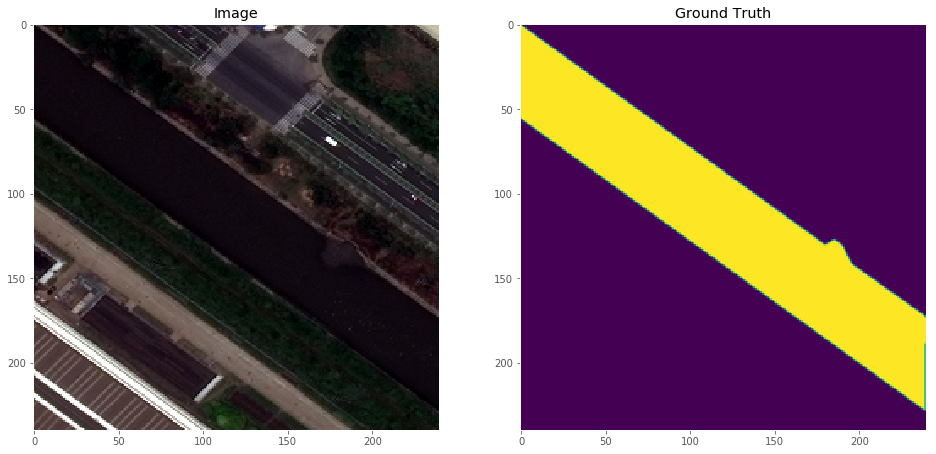

8/4000


In [59]:
for i in range(Y_train.shape[0]):
    x = X_train[i]
    y = Y_train[i]

    # Pick out which target to look at
    CLASS_NO = 0
    targ = y[:, :, CLASS_NO]

    # Plot it
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,8))
    ax1.imshow(scale_bands(x[:,:,[4,2,1]])) # This index starts at 0, so I had to decrement
    ax2.imshow(targ, vmin=0, vmax=1)

    ax1.set_title('Image')
    ax2.set_title('Ground Truth');
    ax1.grid();
    ax2.grid();
    plt.show()
    
    print('{}/{}'.format(i+1, Y_train.shape[0]))
    
    if i == 7:
        break
    
    time.sleep(1)
    display.clear_output(wait=True)

# print('DONE')